In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

# 1) Pfad festlegen
data_dir = r"C:\Users\lpera\audio_dataset"  # Rohstring (r"") wegen Backslashes in Windows

# 2) YAMNet-Spezifikation erstellen
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH
)

# 3) Trainings-DataLoader
train_data = audio_classifier.DataLoader.from_folder(
    spec,
    os.path.join(data_dir, 'train'),
    cache=True
)

# 4) Split in Train/Validation
train_data, validation_data = train_data.split(0.8)

# 5) Test-DataLoader
test_data = audio_classifier.DataLoader.from_folder(
    spec,
    os.path.join(data_dir, 'test'),
    cache=True
)

# 6) Modell trainieren
batch_size = 32
epochs = 50

model = audio_classifier.create(
    train_data,
    spec,
    validation_data=validation_data,
    batch_size=batch_size,
    epochs=epochs
)

# 7) Evaluieren
print("Evaluation auf Testdaten:")
metrics = model.evaluate(test_data)


INFO:tensorflow:Checkpoints are stored in C:\Users\lpera\AppData\Local\Temp\tmpff2ycxci


INFO:tensorflow:Checkpoints are stored in C:\Users\lpera\AppData\Local\Temp\tmpff2ycxci


OSError: SavedModel file does not exist at: C:\Users\lpera\AppData\Local\Temp\tfhub_modules\9616fd04ec2360621642ef9455b84f4b668e219e\{saved_model.pbtxt|saved_model.pb}

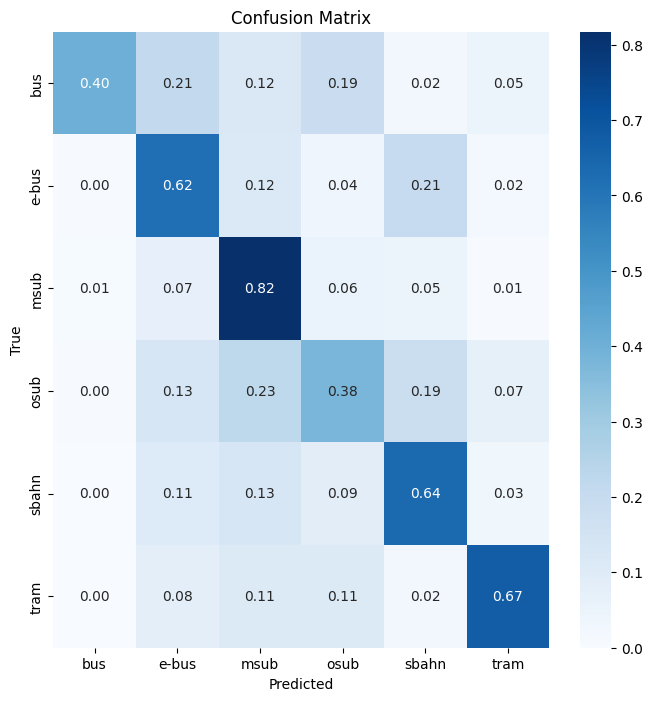

In [10]:


# Optional: Confusion-Matrix ausgeben
conf_matrix = model.confusion_matrix(test_data).numpy()
labels = test_data.index_to_label

plt.figure(figsize=(8,8))
sns.heatmap(
    conf_matrix / conf_matrix.sum(axis=1, keepdims=True),
    annot=True, xticklabels=labels, yticklabels=labels,
    cmap="Blues", fmt=".2f"
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

data_dir = r"C:\Users\lpera\audio_dataset"  # Rohstring (r"") wegen Backslashes in Windows

model = audio_classifier.create(
    train_data,
    spec,
    validation_data=validation_data,
    batch_size=batch_size,
    epochs=epochs
)

# 8) Export als TFLite
export_dir = os.path.join(data_dir, "exported_model")

model.export(
    export_dir,
    tflite_filename="vehicle_sounds.tflite",
    label_filename="vehicle_labels.txt",
    export_format=[mm.ExportFormat.TFLITE, mm.ExportFormat.LABEL]
)

# Optional: zusätzlich SavedModel
model.export(
    export_dir,
    export_format=[mm.ExportFormat.SAVED_MODEL]
)

print("Modell im Ordner:", export_dir)


NameError: name 'train_data' is not defined

In [1]:
import os
import numpy as np
import tensorflow as tf
from scipy.io import wavfile
import random
import glob
import json

# 1) Pfade festlegen
tflite_model_path = r"C:\Users\lpera\audio_dataset\exported_model\vehicle_sounds.tflite"  # Pfad zu deinem TFLite-Modell
data_dir = r"C:\Users\lpera\audio_dataset"  # Pfad zu deinem Datensatz
labels_txt_path = r"C:\Users\lpera\audio_dataset\exported_model\vehicle_labels.txt"  # Pfad zur vehicle_labels.txt
yamnet_class_map_csv_path = r"C:\Users\lpera\audio_dataset\exported_model\saved_model\assets\yamnet_class_map.csv"  # Pfad zur yamnet_class_map.csv
# Optional: vehicle_sounds.json, falls benötigt
vehicle_sounds_json_path = r"C:\Users\lpera\audio_dataset\exported_model\vehicle_sounds.json"

# 2) Laden der vehicle_labels.txt als index_to_label Mapping
try:
    with open(labels_txt_path, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
    index_to_label = {str(index): label for index, label in enumerate(labels)}
    print("vehicle_labels.txt erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden der vehicle_labels.txt: {e}")
    exit(1)

# 3) Laden der yamnet_class_map.csv als yamnet_labels Mapping
try:
    yamnet_labels = {}
    with open(yamnet_class_map_csv_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',', 1)  # Annahme: CSV hat 'index,label' Format
            if len(parts) != 2:
                continue  # Überspringe ungültige Zeilen
            index, label = parts
            yamnet_labels[int(index)] = label
    print("yamnet_class_map.csv erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden der yamnet_class_map.csv: {e}")
    exit(1)

# Optional: Laden der vehicle_sounds.json, falls benötigt
# Dies hängt davon ab, was diese Datei enthält
# Wenn sie zusätzliche Informationen enthält, die du benötigst, kannst du sie hier laden
try:
    with open(vehicle_sounds_json_path, 'r') as f:
        vehicle_sounds_data = json.load(f)
    print("vehicle_sounds.json erfolgreich geladen.")
except FileNotFoundError:
    print("vehicle_sounds.json nicht gefunden. Wird übersprungen.")
    vehicle_sounds_data = None
except Exception as e:
    print(f"Fehler beim Laden der vehicle_sounds.json: {e}")
    vehicle_sounds_data = None

# 4) Laden des TensorFlow Lite Modells
try:
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    print("TensorFlow Lite Modell erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden des TensorFlow Lite Modells: {e}")
    exit(1)

# 5) Holen der Eingabe- und Ausgabetensor-Details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Eingabe Details: {input_details}")
print(f"Ausgabe Details: {output_details}")

# Bestimmen der Output-Indizes
# Identifiziere die Outputs basierend auf ihrer Größe oder Namen
# Angenommen, die YAMNet-Ausgabe ist die größere (521 Klassen)
yamnet_output_index = None
custom_output_index = None

for output in output_details:
    if output['shape'][1] == 521:
        yamnet_output_index = output['index']
    elif output['shape'][1] == 6:
        custom_output_index = output['index']

if yamnet_output_index is None or custom_output_index is None:
    print("Fehler: Kann die Ausgabe-Indizes für YAMNet oder Custom-Head nicht finden.")
    exit(1)

# 6) Hilfsfunktion, um eine zufällige WAV-Datei aus dem Test-Ordner zu holen
def get_random_audio_file():
    test_folder = os.path.join(data_dir, "test")
    file_pattern = os.path.join(test_folder, "**", "*.wav")
    all_files = glob.glob(file_pattern, recursive=True)
    if not all_files:
        raise FileNotFoundError("Keine WAV-Dateien im Test-Ordner gefunden.")
    return random.choice(all_files)

# 7) Beispiel: Hol dir eine zufällige Audiodatei
try:
    random_audio = get_random_audio_file()
    print(f"Test audio path: {random_audio}")
except Exception as e:
    print(f"Fehler beim Auswählen einer Audiodatei: {e}")
    exit(1)

# 8) Lade die Audiodaten
try:
    sample_rate, audio_data = wavfile.read(random_audio, 'rb')
    print(f"Sampling Rate: {sample_rate} Hz")
except Exception as e:
    print(f"Fehler beim Lesen der Audiodatei: {e}")
    exit(1)

# 9) Überprüfen der Sampling-Rate
expected_sample_rate = 16000  # Beispiel: 16 kHz, passe es an dein Modell an
if sample_rate != expected_sample_rate:
    print(f"Warnung: Die Sampling-Rate der Audiodatei ({sample_rate} Hz) stimmt nicht mit der erwarteten ({expected_sample_rate} Hz) überein.")
    # Optional: Resample die Audiodatei auf die erwartete Sampling-Rate
    try:
        import librosa
        audio_data, sample_rate = librosa.load(random_audio, sr=expected_sample_rate)
        print(f"Audiodatei erfolgreich auf {expected_sample_rate} Hz resampled.")
    except ImportError:
        print("LibROSA ist nicht installiert. Installiere es mit `pip install librosa`, um die Audiodatei zu resamplen.")
        exit(1)
    except Exception as e:
        print(f"Fehler beim Resamplen der Audiodatei: {e}")
        exit(1)

# 10) Normalisieren, falls 16-Bit-PCM
if audio_data.dtype == np.int16:
    audio_data = audio_data.astype(np.float32) / np.iinfo(np.int16).max
elif audio_data.dtype == np.int32:
    audio_data = audio_data.astype(np.float32) / np.iinfo(np.int32).max
else:
    audio_data = audio_data.astype(np.float32)

# 11) Bestimme, wie viele Samples dein Modell als Input erwartet
input_shape = input_details[0]['shape']
input_size = input_shape[1]  # z.B. 15600
print(f"Erwartete Eingabegröße (Samples): {input_size}")

# 12) Splitte das Audio in Frames von der Größe 'input_size', direkt hintereinander
splitted_audio_data = tf.signal.frame(
    audio_data, 
    frame_length=input_size, 
    frame_step=input_size, 
    pad_end=True, 
    pad_value=0.0
)

print(f"Original audio length (samples): {len(audio_data)}")
print(f"Number of windows for inference: {splitted_audio_data.shape[0]}")

# 13) Inferenz pro Fenster durchführen
results = []
print("Result of the window i:  YourModelClass -> score,   (YAMNet's top1 -> score)")

for i, chunk in enumerate(splitted_audio_data):
    # Bereite den Input-Tensor vor
    input_data = np.expand_dims(chunk.numpy(), axis=0).astype(np.float32)  # Shape: [1, input_size]

    # Setze den Input-Tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Führe die Inferenz durch
    interpreter.invoke()

    # Holen der YAMNet-Ausgabe
    yamnet_output = interpreter.get_tensor(yamnet_output_index)[0]  # Shape: [521]
    # Holen der Custom-Head-Ausgabe
    custom_output = interpreter.get_tensor(custom_output_index)[0]  # Shape: [6]

    results.append(custom_output)

    # Bestimme Index der höchsten Klasse im Custom-Head
    my_model_index = np.argmax(custom_output)
    my_model_label = index_to_label.get(str(my_model_index), "Unknown")
    my_model_conf  = custom_output[my_model_index]

    # Bestimme Index der höchsten Klasse in YAMNet
    yamnet_index = np.argmax(yamnet_output)
    yamnet_label = yamnet_labels.get(yamnet_index, "Unknown")
    yamnet_conf  = yamnet_output[yamnet_index]

    # Optional: Filterung basierend auf YAMNet-Ausgabe
    # Beispiel: Nur wenn YAMNet eine relevante Klasse erkannt hat (z.B. Fahrzeugklassen)
    # Definiere eine Liste von relevanten YAMNet-Klassen, die für deine Anwendung wichtig sind
    relevant_yamnet_classes = ['car', 'motorcycle', 'truck', 'bus']  # Passe diese Liste an deine Anforderungen an

    if yamnet_label.lower() in relevant_yamnet_classes:
        # Nur relevante Ergebnisse speichern oder anzeigen
        print(f"Result of window {i}:  {my_model_label} -> {my_model_conf:.3f},  "
              f"(YAMNet: {yamnet_label} -> {yamnet_conf:.3f})")
    else:
        # Irrelevante Ergebnisse markieren oder ignorieren
        print(f"Result of window {i}:  [Irrelevant] {my_model_label} -> {my_model_conf:.3f},  "
              f"(YAMNet: {yamnet_label} -> {yamnet_conf:.3f})")

# 14) Mittelung der Ergebnisse über alle Fenster
if results:
    results_np = np.array(results)  # shape = (num_windows, 6)
    mean_scores = results_np.mean(axis=0)  # => shape = (6,)
    best_idx = mean_scores.argmax()
    best_label = index_to_label.get(str(best_idx), "Unknown")
    print(f"\nMean result over all windows: {best_label} -> {mean_scores[best_idx]:.3f}")
else:
    print("Keine Ergebnisse zur Mittelung vorhanden.")


Fehler beim Laden der vehicle_labels.txt: [Errno 2] No such file or directory: 'C:\\Users\\lpera\\audio_dataset\\exported_model\\vehicle_labels.txt'
Fehler beim Laden der yamnet_class_map.csv: [Errno 2] No such file or directory: 'C:\\Users\\lpera\\audio_dataset\\exported_model\\saved_model\\assets\\yamnet_class_map.csv'
vehicle_sounds.json nicht gefunden. Wird übersprungen.
Fehler beim Laden des TensorFlow Lite Modells: Could not open 'C:\Users\lpera\audio_dataset\exported_model\vehicle_sounds.tflite'.


NameError: name 'interpreter' is not defined

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

# 1) Pfad festlegen
data_dir = r"C:\Users\lpera\audio_dataset"  # Rohstring (r"") wegen Backslashes in Windows

# 2) YAMNet-Spezifikation erstellen
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=False,  # Setzen Sie dies auf False
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH
)

# 3) Trainings-DataLoader
train_data = audio_classifier.DataLoader.from_folder(
    spec,
    os.path.join(data_dir, 'train'),
    cache=True
)

# 4) Split in Train/Validation
train_data, validation_data = train_data.split(0.8)

# 5) Test-DataLoader
test_data = audio_classifier.DataLoader.from_folder(
    spec,
    os.path.join(data_dir, 'test'),
    cache=True
)

# 6) Modell trainieren
batch_size = 32
epochs = 50

model = audio_classifier.create(
    train_data,
    spec,
    validation_data=validation_data,
    batch_size=batch_size,
    epochs=epochs
)

# 7) Evaluieren
print("Evaluation auf Testdaten:")
metrics = model.evaluate(test_data)
print(metrics)

# Optional: Confusion-Matrix ausgeben
conf_matrix = model.confusion_matrix(test_data).numpy()
labels = test_data.index_to_label

plt.figure(figsize=(8,8))
sns.heatmap(
    conf_matrix / conf_matrix.sum(axis=1, keepdims=True),
    annot=True, xticklabels=labels, yticklabels=labels,
    cmap="Blues", fmt=".2f"
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 8) Export als TFLite
export_dir = os.path.join(data_dir, "exported_model")

model.export(
    export_dir,
    tflite_filename="vehicle_sounds.tflite",
    label_filename="vehicle_labels.txt",
    export_format=[mm.ExportFormat.TFLITE, mm.ExportFormat.LABEL]
)

# Optional: zusätzlich SavedModel
model.export(
    export_dir,
    export_format=[mm.ExportFormat.SAVED_MODEL]
)

print("Modell im Ordner:", export_dir)


INFO:tensorflow:Checkpoints are stored in C:\Users\lpera\AppData\Local\Temp\tmp4kkeol6r


OSError: SavedModel file does not exist at: C:\Users\lpera\AppData\Local\Temp\tfhub_modules\9616fd04ec2360621642ef9455b84f4b668e219e\{saved_model.pbtxt|saved_model.pb}

C:\Users\lpera\anaconda3\envs\python_37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


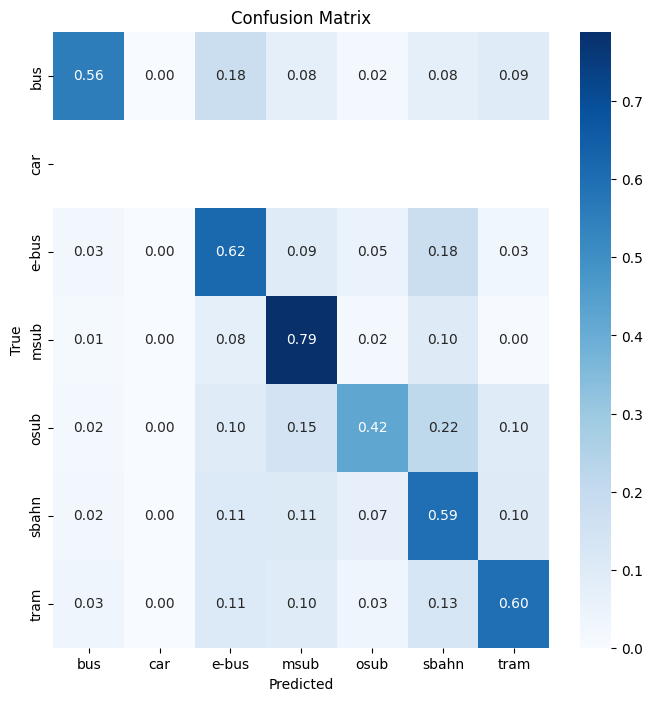

In [25]:


# Optional: Confusion-Matrix ausgeben
conf_matrix = model.confusion_matrix(test_data).numpy()
labels = test_data.index_to_label

plt.figure(figsize=(8,8))
sns.heatmap(
    conf_matrix / conf_matrix.sum(axis=1, keepdims=True),
    annot=True, xticklabels=labels, yticklabels=labels,
    cmap="Blues", fmt=".2f"
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [43]:
import numpy as np

test_ds = test_data.gen_dataset()
for sample_audio, sample_label in test_ds.take(10):  # 10 zufällige Testbeispiele
    prediction = model.model(sample_audio[None, ...])  # Batch-Dimension hinzufügen
    predicted_label = np.argmax(prediction.numpy(), axis=1)[0]

    # Konvertiere sample_label in eine ganze Zahl
    true_label = sample_label.numpy().astype(int).item()  # `.astype(int).item()` stellt sicher, dass es ein einzelner Integer ist

    print(f"Echtes Label: {test_data.index_to_label[true_label]}")
    print(f"Vorhergesagtes Label: {test_data.index_to_label[int(predicted_label)]}")
    print("----------")


ValueError: can only convert an array of size 1 to a Python scalar

In [1]:
import os
import glob

# Pfade zu den Train- und Test-Ordnern für "car"
train_car_path = r"C:\Users\lpera\audio_dataset\train\car"
test_car_path = r"C:\Users\lpera\audio_dataset\test\car"

# Alle .wav-Dateien (oder andere Formate, die du verwendest) im jeweiligen Ordner finden
train_files = glob.glob(os.path.join(train_car_path, "*.wav"))
test_files = glob.glob(os.path.join(test_car_path, "*.wav"))

print(f"Anzahl der 'car'-Samples im Training-Set: {len(train_files)}")
print(f"Anzahl der 'car'-Samples im Test-Set: {len(test_files)}")


Anzahl der 'car'-Samples im Training-Set: 2282
Anzahl der 'car'-Samples im Test-Set: 570


In [2]:
# Pfad zur vehicle_labels.txt
labels_file = r"C:\Users\lpera\audio_dataset\exported_model\vehicle_labels.txt"

with open(labels_file, "r") as f:
    labels = [line.strip() for line in f.readlines()]

print("Labels aus der Datei:")
for label in labels:
    print(label)


Labels aus der Datei:
bus
car
e-bus
msub
osub
sbahn
tram


Datei: C:\Users\lpera\audio_dataset\train\car\car_02.wav
Samplingrate: 16000
Audio-Länge in Sekunden: 1.77


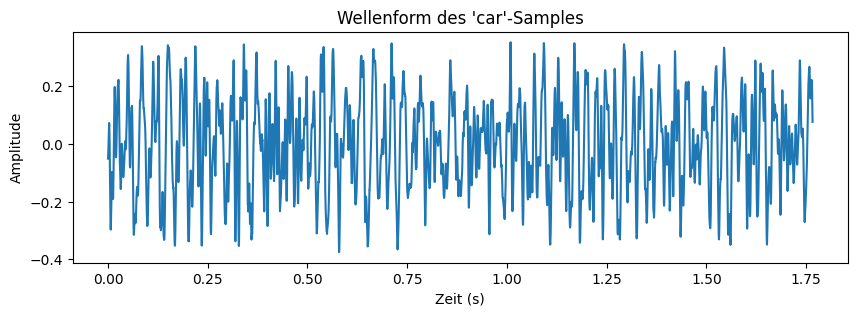

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Ein Beispiel-Sample aus dem Training-Set auswählen
sample_file = train_files[0]  # Nimm das erste Sample

# Lade das Audio
audio, sr = librosa.load(sample_file, sr=None)  # sr=None, um die originale Samplingrate zu erhalten

print(f"Datei: {sample_file}")
print(f"Samplingrate: {sr}")
print(f"Audio-Länge in Sekunden: {len(audio)/sr:.2f}")

# Optional: Wellenform plotten
plt.figure(figsize=(10, 3))
plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
plt.xlabel("Zeit (s)")
plt.ylabel("Amplitude")
plt.title("Wellenform des 'car'-Samples")
plt.show()


In [1]:
test_data = audio_classifier.DataLoader.from_folder(
    spec,
    r"C:\Users\lpera\audio_dataset\test",
    cache=True
)
for label, count in test_data.index_to_count.items():
    print(f"{label}: {count} Samples")


NameError: name 'audio_classifier' is not defined